In [ ]:
!pip install pandas

In [1]:
import os
THREADS = 1
os.environ["OMP_NUM_THREADS"] = str(THREADS)
os.environ["OPENBLAS_NUM_THREADS"] = str(THREADS) 
os.environ["MKL_NUM_THREADS"] = str(THREADS) 
os.environ["VECLIB_MAXIMUM_THREADS"] = str(THREADS) 
os.environ["NUMEXPR_NUM_THREADS"] = str(THREADS)
import cupy as cp
import pystrel as ps
import pandas as pd
import scipy.special as sp
import matplotlib.pyplot as plt

In [ ]:
device = "cpu"
sparsity = "dense"

def spectrum_benchmark(*, L = 10):
    h = 1.0
    J = -1.0
    gamma = 0.5

    model = ps.Model({"terms":{
        "gamma": { (i, i+1): gamma for i in range(L - 1)},
        "Jz": { (i, i+1): J for i in range(L - 1)},
        "hz": { i: h for i in range(L)},
    }})
    hamiltonian = model.build_hamiltonian(device=device, sparsity=sparsity)
    _ = ps.spectrum.get_full_spectrum(hamiltonian)
    if device == "gpu":
        cp.cuda.Device().synchronize()

def run(L):
    runs = %timeit -q -o -n 10 spectrum_benchmark(L=L)
    return int(sp.binom(L, L / 2)), runs.average

spectrum_benchmark(L=10)
sizes, times = [], []
for i in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    size, time = run(i)
    sizes.append(size)
    times.append(time)
    print(i, size, time)

df = pd.DataFrame({"size": sizes, "time": times}).set_index("size")
df.to_csv(f"tmp_{spectrum_benchmark.__name__}_{sparsity}_{device}_{THREADS}.csv")
df

In [ ]:
device = "gpu"

def spectrum_benchmark(*, L = 10):
    h = 1.0
    J = -1.0
    gamma = 0.5

    model = ps.Model({"terms":{
        "gamma": { (i, i+1): gamma for i in range(L - 1)},
        "Jz": { (i, i+1): J for i in range(L - 1)},
        "hz": { i: h for i in range(L)},
    }})
    hamiltonian = model.build_hamiltonian(device=device, sparsity="sparse")
    _ = ps.spectrum.get_partial_spectrum(hamiltonian, k=5)
    if device == "gpu":
        cp.cuda.Device().synchronize()

def run(L):
    runs = %timeit -q -o -n 5 -r 1 spectrum_benchmark(L=L)
    return int(sp.binom(L, L / 2)), runs.average

spectrum_benchmark(L=10)
sizes, times = [], []
for i in [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
    size, time = run(i)
    sizes.append(size)
    times.append(time)
    print(i, size, time)

df = pd.DataFrame({"size": sizes, "time": times}).set_index("size")
df.to_csv(f"tmp_{spectrum_benchmark.__name__}_sparse_{device}_{THREADS}.csv")
df

## Results

### Eigenproblem (dense)

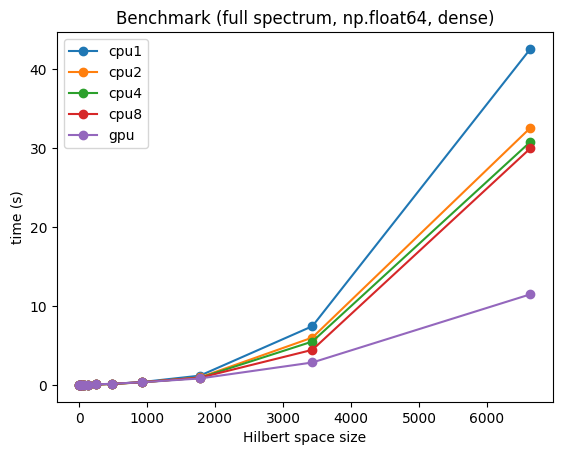

In [13]:
cpu1 = pd.read_csv("tmp_spectrum_benchmark_dense_cpu_1.csv")
cpu2 = pd.read_csv("tmp_spectrum_benchmark_dense_cpu_2.csv")
cpu4 = pd.read_csv("tmp_spectrum_benchmark_dense_cpu_4.csv")
cpu8 = pd.read_csv("tmp_spectrum_benchmark_dense_cpu_8.csv")
gpu = pd.read_csv("tmp_spectrum_benchmark_dense_gpu_1.csv")
size = cpu4["size"]


def plot(df, label):
    plt.plot(df["size"], df["time"], '-o', label=label)


plot(cpu1, label="cpu1")
plot(cpu2, label="cpu2")
plot(cpu4, label="cpu4")
plot(cpu8, label="cpu8")
plot(gpu, label="gpu")
plt.legend()
plt.title("Benchmark (full spectrum, np.float64, dense)")
plt.xlabel("Hilbert space size")
plt.ylabel("time (s)")
plt.show()

### Eigenproblem (sparse)

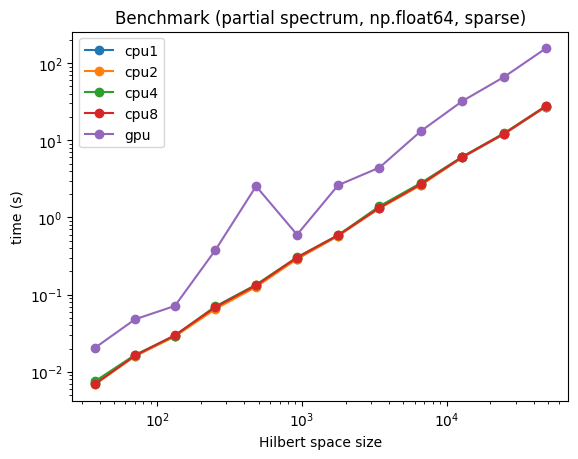

In [8]:
cpu1 = pd.read_csv("tmp_spectrum_benchmark_sparse_cpu_1.csv")
cpu2 = pd.read_csv("tmp_spectrum_benchmark_sparse_cpu_2.csv")
cpu4 = pd.read_csv("tmp_spectrum_benchmark_sparse_cpu_4.csv")
cpu8 = pd.read_csv("tmp_spectrum_benchmark_sparse_cpu_8.csv")
gpu = pd.read_csv("tmp_spectrum_benchmark_sparse_gpu_1.csv")
size = cpu4["size"]


def plot(df, label):
    plt.plot(df["size"], df["time"], '-o', label=label)

plt.loglog()
plot(cpu1, label="cpu1")
plot(cpu2, label="cpu2")
plot(cpu4, label="cpu4")
plot(cpu8, label="cpu8")
plot(gpu, label="gpu")
plt.legend()
plt.title("Benchmark (partial spectrum, np.float64, sparse)")
plt.xlabel("Hilbert space size")
plt.ylabel("time (s)")
plt.show()